# Course 2: Sensor Fusion
## Part 1: 3D Object Detection
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Explore the sensor modalities used in the Waymo Open Dataset;
* Examine the technical specifications of the sensors used in the dataset;
* Visualise the range images and convert them to 3D point clouds;

## 1. Introduction

In [1]:
### Importing required modules

In [2]:
import copy
import cv2
from easydict import EasyDict as edict
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import open3d
from open3d import JVisualizer
import sys
from tools.waymo_reader.simple_waymo_open_dataset_reader import dataset_pb2, label_pb2
from tools.waymo_reader.simple_waymo_open_dataset_reader import WaymoDataFileReader
from tools.waymo_reader.simple_waymo_open_dataset_reader import utils as waymo_utils
import zlib

In [3]:
!python --version

Python 3.7.6


In [4]:
### Setting environment variables and parameters

In [5]:
ENV_COLAB = False               # True if running in Google Colab instance

In [6]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/2-Sensor-Fusion'
DIR_BASE = os.path.abspath(DIR_BASE)
DIR_BASE

'/home/workspace'

In [7]:
# add exercise directories to python path to enable relative imports
EXE_L1 = 'lesson-1-lidar-sensor/exercises/starter'
EXA_L1 = 'lesson-1-lidar-sensor/examples'
EXE_L2 = 'lesson-2-object-detection/exercises/starter'
EXA_L2 = 'lesson-2-object-detection/examples'
sys.path.append(os.path.normpath(os.path.join(DIR_BASE, EXE_L1)))
sys.path.append(os.path.normpath(os.path.join(DIR_BASE, EXA_L1)))
sys.path.append(os.path.normpath(os.path.join(DIR_BASE, EXE_L2)))
sys.path.append(os.path.normpath(os.path.join(DIR_BASE, EXA_L2)))

### 1.1 The Waymo Open Dataset

The Waymo Open Dataset [1] is a multi-sensor, multi-modal dataset used for autonomous driving tasks. In this dataset are 20 sec. long video clip segments capturing the driving environment, i.e., vehicle surroundings, from five LiDAR sensors and five RGB camera sensors surrounding the ego-vehicle.

#### Sensor Layouts

The positioning of the camera and LiDAR (denoted "Laser") sensors around the vehicle has been replicated in the following figure:

<img src="figures/Exercises/2022-10-20-Figure-1-Sensor-Placement.png" height="80%" width="80%" alt="Fig. 1. The Waymo Open Dataset: sensor layout and coordinate systems with respect to the ego-vehicle.">
$$
\begin{align}
\textrm{Fig. 1. The Waymo Open Dataset: sensor layout and coordinate systems with respect to the ego-vehicle.}
\end{align}
$$

The camera sensors capture images of the driving domain at varying resolutions from a horizontal field-of-view (HFOV) of $\pm 25.2^\circ$. The HFOV is an angle provided with respect to the $x$-axis formed by the $x$-$y$ plane of the Camera Sensor frame (described below).

#### Coordinate Systems

As defined in the [accompanying paper](https://arxiv.org/pdf/1912.04838.pdf) provided with the Waymo Open Dataset [1], we have the following coordinate systems which follow the right-hand rule:

* **Global frame**: an East-North-Up coordinate system defined with respect to the driving environment set prior to vehicle motion;
    * $\mathrm{Up}(z)$: aligned with the gravity vector;
    * $\mathrm{East}(x)$: points directly east along the line of latitude;
    * $\mathrm{North}(y)$: points towards the north pole;
* **Vehicle frame**: a Cartesian coordinate system $\left(x, y, z\right)$ defined with respect to the ego-vehicle;
    * $x$-axis: positive _forwards_ in the direction of motion of the vehicle;
    * $y$-axis: positive _left_ of the direction of motion of the vehicle;
    * $z$-axis: positive _upwards_ (perpendicular) to the direction of motion of the vehicle;
* **Sensor frame**: a Cartesian coordinate system $\left(x, y, z\right)$ defined with respect to each sensor;
    * _LiDAR sensor frame_:
        * $x$-$y$ axes: defined with respect to the individual LiDAR sensor;
        * $z$-axis: positive _upwards_;
    * _Camera sensor frame_:
        * $x$-axis: points down the lens barrel out of the lens;
        * $z$-axis: points _upwards_;
* **Image frame**: a 2D Cartesian coordinate system $\left(x, y\right)$ defined for each camera image;
    * $x$-axis: positive along the image width (i.e., column index starting from the left);
    * $y$-axis: positive along the image height (i.e., row index starting from the top).

The Vehicle frame is defined as a $4x4$ transformation matrix from the vehicle-to-global frame. The Camera sensor frame is placed at the centre of the lens. The origin of the Image frame is defined to be the top-left corner.

#### LiDAR Data

The LiDAR data provided in the Waymo Open Dataset is in the form of range images, one for each return from each of the five LiDAR sensors placed around the ego vehicle. Each range image pixel corresponds to a LiDAR return. Therefore, the height and width are determined by the resolution of the inclination and azimuth in the LiDAR Sensor frame. Each inclination for each range image is provided; $\mathrm{Row} 0$ (the top row of the image, denotes 'pitch' angle) corresponds to the maximum inclination, $\mathrm{Column} 0$ (the left-most column of the image, denotes 'yaw' angle) corresponds to the negative $x$-axis (i.e., the backwards direction). The centre of the image corresponds to the positive $x$-axis (i.e., the forward direction). An _azimuth correction_ is needed to make sure the centre of the range image corresponds to the positive $x$-axis (see code in [`l1_exercises.py`]() for further explanation on this).

Each pixel in the range image includes the following properties:
* **Range**: Distance between the LiDAR point and the origin in LiDAR Sensor frame;
* **Intensity**: Measurement indicating the return strength of the laser pulse generating the LiDAR point, based partly on reflectivity of the object struck by the laser pulse;
* **Elongation**: Elongation of the laser pulse beyond its nominal width, used in conjunction with intensity value to infer environmental factors e.g., rain, fog, dust. For example, high elongation and low intensity values suggest the presence of atmospheric hazards;
* **No label zone**: Field indicating whether the LiDAR point falls into a no label zone, i.e., an area ignored for labelling;
* **Vehicle pose**: Pose at the time the LiDAR point is captured;
* **Camera projection**: Accurate LiDAR point to camera image projections (rolling shutter effect compensated).

##### LiDAR Spherical coordinate system

As defined in the [accompanying paper](https://arxiv.org/pdf/1912.04838.pdf) provided with the Waymo Open Dataset [1], we have a Cartesian coordinate system for the LiDAR sensor frame. A point $\left(x, y, z\right)$ in the LiDAR Cartesian coordinate system can be uniquely transformed to a $\left(\mathrm{range}, \mathrm{azimuth}, \mathrm{inclination}\right)$ tuple in the LiDAR Spherical coordinate system using the following equations:

$$
\begin{align}
\mathrm{range} &= \sqrt{x^2 + y^2 + z^2}, \\
\mathrm{azimuth} &= \mathrm{atan2}\left(y, x\right), \\
\mathrm{inclination} &= \mathrm{atan2}\left(z, \sqrt{x^2 + y^2}\right). \\
\end{align}
$$

## 2. Programming Task

In [8]:
data_filename = 'training_segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord'
# data_filename = 'training_segment-10072231702153043603_5725_000_5745_000_with_camera_labels.tfrecord'
# data_filename = 'training_segment-10963653239323173269_1924_000_1944_000_with_camera_labels.tfrecord'
show_only_frames = [0, 1]  # show only frames in interval for debugging

In [9]:
data_fullpath = os.path.join('dataset', data_filename)

In [10]:
datafile = WaymoDataFileReader(data_fullpath)
datafile_iter = iter(datafile)

In [11]:
### Get the next frame in the Waymo dataset file
frame = next(datafile_iter)

### 2.1. The LiDAR Sensor

In [12]:
import l1_examples
import l1_exercises

In [13]:
####### LESSON 1 EXERCISES & EXAMPLES START #######
lidar_name = dataset_pb2.LaserName.TOP

#### 2.1.1: LiDAR Data in the Waymo Dataset

##### Printing number of vehicles

In [14]:
# Exercise C1-3-1 : print no. of vehicles
l1_exercises.print_no_of_vehicles(frame)

Exercise C1-3-1
Number of labelled vehicles in current frame: 6


From the above we see that there are six `TYPE_VEHICLE` objects labelled in frame '0' of the first segment file. In frame '1' we expect to see seven vehicle objects. Note that the number of vehicles shown here is based on the ground-truth LiDAR data annotations available from the `TOP` sensor, which may differ from the ground-truth _camera_ data annotations available from any of the five camera sensors.

##### Display camera image

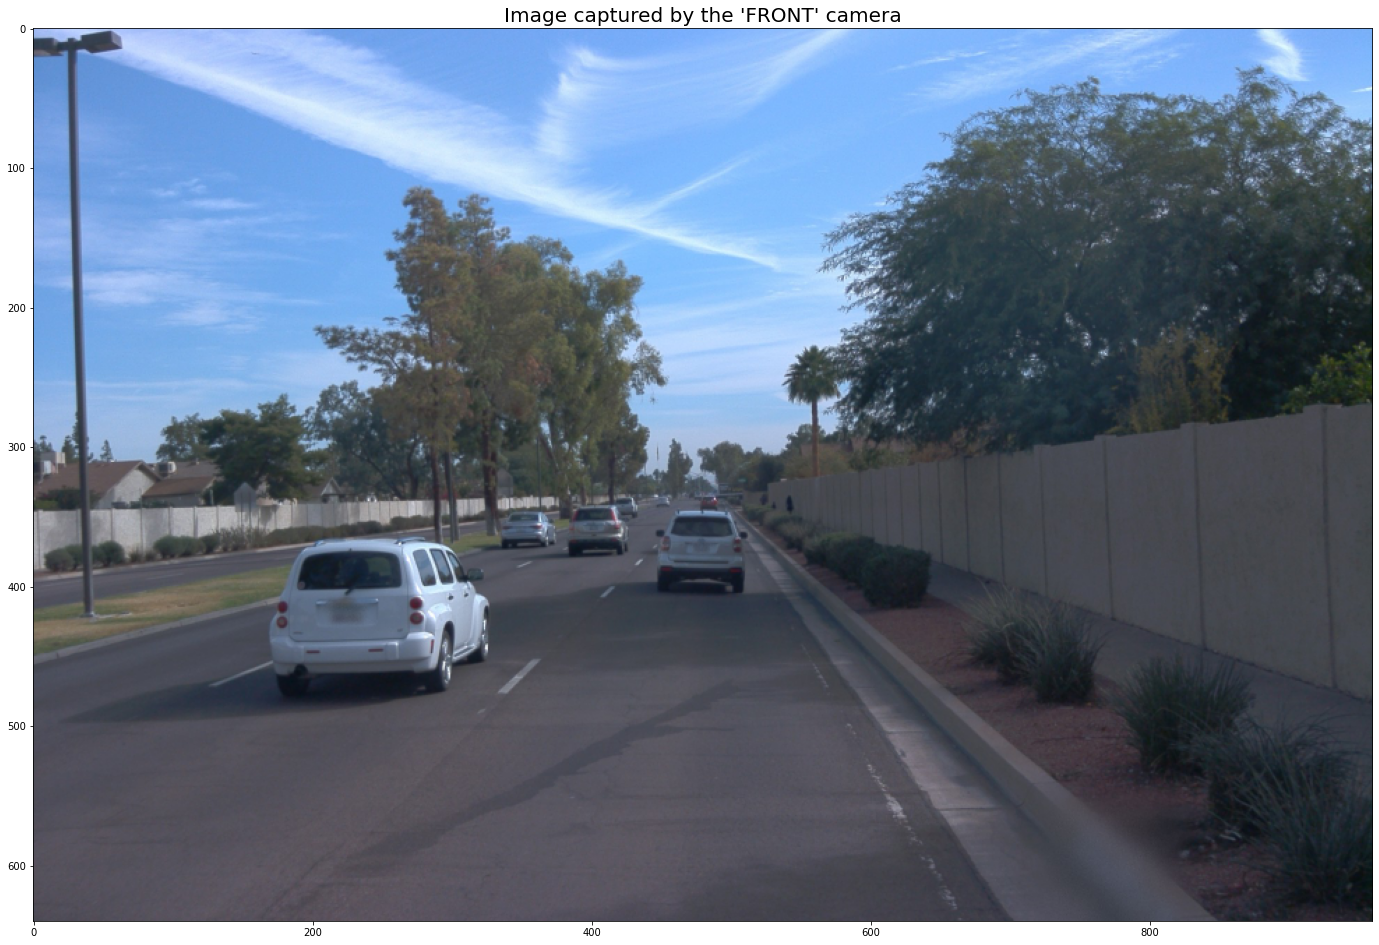

In [15]:
# Example C1-3-2 : display camera image
l1_examples.display_image(frame, inline=True)

Here we see the first frame in segment one captured by the `'FRONT'` camera sensor.

##### Printing vertical field-of-view

We can compute the vertical angular resolution of the range image using the PBEA (Projection By Elevation Angle) method [3]. The corresponding formula in terms of angular resolution $\theta_{res}$ is as follows:
$$
\begin{align}
\theta_{res} &= \left(\theta_{up} - \theta_{down}\right) / h,
\end{align}
$$

for $\theta_{up}$ and $\theta_{down}$, the maximum and minimum elevation angles, respectively.

In [16]:
# Example C1-3-3 : print angle of vertical field of view
l1_examples.print_vfov_lidar(frame, lidar_name)

Vertical field-of-view (deg) of 'TOP' sensor: 20.360222720319797


##### Extrinsic calibration matrix

Also given in the Waymo Open Dataset are the camera and LiDAR sensor calibration matrices. We can extract the calibration data for a given LiDAR sensor in the `frame` using, for example, the following
```
lidar_name = dataset_pb2.LaserName.TOP
calib_lidar = [obj for obj in frame.context.laser_calibrations if obj.name == lidar_name][0]
```

To obtain the extrinsic calibration matrix from the calibration data above, simply access its attribute value with the access chain:
```
calib_lidar.extrinsic.transform
```
which should return a $4x4$ matrix. For example, we might have

$$
\begin{bmatrix}
    −0.8526719509207284 & 0.5224451202853144 & 0.0012807822227881296 & 0.0 \\
    −0.5224378704141576 & −0.8526692389088371 & −0.0037202924272838555 & 0.0 \\
    −0.0030357322277815815− & 0.0025030598650299957 & 0.9999922594806188 & 0.0 \\ 
    1.43 & 0.0 & 2.184 & 1.0 \\
\end{bmatrix}
$$

which tells us that the `TOP` LiDAR sensor is located $+1.43 \ m$ away from the origin of the vehicle coordinate system and has a height of $+2.184 \ m$.

##### LiDAR technical properties

###### Computing range to target

Here we used a [pulsed LiDAR](https://en.wikipedia.org/wiki/Pulsed_laser) system (opposed to e.g., FMCW LiDAR). In brief, a pulsed LiDAR system consists of a source emitting short bursts of narrow-beam laser light into the scene. When the beamed light hits an object, a fraction of the laser light is refracted back to the LiDAR sensor. Based on the [Time-of-Flight](https://en.wikipedia.org/wiki/Time-of-flight_camera#Principle) (ToF) principle we can measure the range $R$ to the target object using the following equation:

$$
\begin{align}
R &= \frac{1}{2n}\cdot c\Delta{t},
\end{align}
$$

where $c$ is the speed of light in vacuum and $n$ is the index of refraction of the propagation medium (e.g., for _air_, this can be assumed to $1.0$).

###### Computing maximum effective range
The maximum range at which a target can be detected is primarily determined by the energy losses of the laser beam during its travel through the atmosphere. The lower the return energy and the higher the ambient noise, the harder it is for the receiver to detect a clear flank. The ratio between signal energy and background noise is referred to as the signal-to-noise ratio (SNR), which can be calculated as follows:

$$
\begin{align}
\mathrm{SNR}(R) &= \frac{P(R)S_{\lambda}M}{\sqrt{2\mathcal{e}B\left[\left(P(R) + P_{B}\right)S_{\lambda} + I_{d}\right]M^{2+x} + \frac{4k T B F}{R_{0}}}}
\end{align}
$$

where we have the following parameters:
* $P(R)$: Power received $(W)$ — can be maximised for a high signal-to-noise (SNR) ratio to achieve a stable and accurate detection on return;
* $S_{\lambda}$: Detector photosensitivity $(A/W)$ — sensitivity of the PMT;
* $M$: Multiplication gain factor — used to amplify the pulse to a detectable range;
* $\mathcal{e}$: Electron charge $(C = A\cdot s)$;
* $B$: Bandwidth of the photodetector $(s^{-1})$ — electronic bandwidth required to process short echo pulses; 
* $P_{B}$: Background light optical power collected by the detector $(W/m^2\cdot\mathrm{sr\cdot \mathrm{Ångström}})$ — average background radiance from external sources over the field-of-view of the detector;
* $I_{d}$: Detector dark current $(A)$ — the current generated by the photo sensor in absence of light;
* $x$: Excess noise factor — due to quantisation noise, i.e., uniformly distributed random (white) noise added to model the noise introduced when signals are sampled using an analogue-to-digital (A/D) converter;
* $k$: Boltzmann constant $(J/K = \frac{V\cdot C}{K})$ — measured at $1.38 \times 10^{-23} J/K$;
* $T$: Absolute temperature $(K)$ — measure of temperature as a function of height above mean sea level in metres;
* $F$: Amplifier noise factor — noise factor of the PMT;
* $R_{0}$: Load resistance $(\Omega = V/R)$ — factor used to model the voltage decay under time constant w.r.t. cable capacitance.


The signal-to-noise measurements are used to estimate how well the desired signal can be discerned from background noise.



###### Beam divergence and coherence
[Beam divergence](https://en.wikipedia.org/wiki/Beam_divergence) measures the amount of angular "drift" in the lateral direction of the emitted laser beam from the source. This is an important factor in determining the smallest resolvable feature size at a given distance, i.e., the angular resolution of the LiDAR sensor in the lateral direction. For example, a LiDAR sensor with a wavelength $\lambda = 1550 nm$ might have a angular resolution of $4 cm$ at a distance of $100m$ due to maximum range and atmospheric conditions.

In order to circumvent signal-to-noise (SNR) issues, the laser energy and the sensitivity of the receiver can be manipulated. However, eye safety regulations limit the power of LiDAR sensors. Many studies, such as [Heinzler 2019](https://arxiv.org/pdf/1906.07675.pdf) and [Haran 2016](https://core.ac.uk/download/pdf/129148998.pdf), have been conducted to consider the effective range and safety of the two most-common wavelengths used in ToF LiDAR systems, the $905nm$ and the $1550nm$ wavelengths. The $\lambda = 905nm$ wavelength has shown to perform substantially better than the $1550nm$ wavelength LiDAR in driving scenarios with rainy/wet conditions, where the atmospheric extinction coefficient can be up to 100x greater for the $1550nm$ LiDAR than the $905nm$ LiDAR wavelength (lower is better) due to H20 absorption in the atmosphere (Wojtanowski, J. et al., 2014) [3]. However, the $905nm$ is a wavelength lies just outside the visible spectrum of the human eye and therefore $1550nm$ is safer on the eyes and is also less susceptible to background noise or interference with the sun.

###### The LiDAR Equation
The classical rangefinder equation (Richmond, R.D. 2010) [4] adapted from Burns, H. 1991, can be used to estimate the peak signal power received $P(R)$ as a return from the target:

$$
\begin{align}
P(R) &= P_{0}\rho\frac{A_0}{\pi R^2} \cdot {\eta_{0}} \cdot e^{-2\gamma R}, \\
\end{align}
$$

where we have the following parameters:
* $P(R)$: Power received $(W)$ — can be maximised for a high signal-to-noise (SNR) ratio to achieve a stable and accurate detection on return;
* $P_{0}$: Peak power transmitted $(W)$ — the more power used in the amplifier, the more photos will make it back to the receiver. There are two factors limiting this: eye safety regulations and power consumption;
* $\rho$: Target reflectivity — the more reflective the target surface is, the more photos will return to the receiver;
* $A_{0}$: Receiver aperture area $(m^{2})$ — same principle as in camera optics, the larger the aperture, the greater the amount of light entering the receiver; 
* $R$: Radius of the optical receiving element $(m)$ — and $\pi * R^2$ the surface area;
* $\eta_{0}$: Transmission coefficient of receiver optics — the degree of scattering in the path to the receiver;
* $\gamma$: Atmospheric extinction coefficient $(m^{-1})$ — the degree of photon loss due to collisions with airborne particles, i.e., the "space loss" due to atmospheric aerosols.

Note that the above optical echo power equation assumes normal incidence (i.e., that the target's surface is perpendicular to the laser beam), the target has lambertian-reflectance surface (i.e., surface brightness is independence of direction of illumination), a flat beam profile, a laser spot smaller than the target, and gamma independence of $R$ (i.e., that the atmospheric extinction does not vary significantly along the measurement path).

##### Print range image shape

In [17]:
# Example C1-5-1 : Load range image
l1_examples.print_range_image_shape(frame, lidar_name)

Range image shape captured by 'TOP' sensor: (64, 2650, 4)


From the above we see that there are $64$ distinct laser LEDs present in the `TOP` LiDAR sensor.

#### 2.1.2: Compute Pitch Angle Resolution

In [18]:
# Exercise C1-5-2 : Compute pitch angle resolution
l1_exercises.print_pitch_resolution(frame, lidar_name)

Exercise C1-5-2
Pitch angle resolution (angular minutes) of 'TOP' sensor: 19.09'


##### Maximum and minimum range

In [19]:
# Example C1-5-3 : Retrieve maximum and minimum distance
l1_examples.get_max_min_range(frame, lidar_name)

Max. range (m) of 'TOP' sensor: 74.99
Min. range (m) of 'TOP' sensor: 0.0


Here we see that the `'TOP'` LiDAR sensor has a range limited to $75m$ (note that all other LiDAR sensors in the dataset have a limited range of $20m$). The range limit for the `'TOP'` LiDAR sensor is set with respect to its scanning method; a $360^{\circ}$ circumference around the vehicle is scanned as the sensor rotates about its vertical axis. One important thing to note about point cloud data captured by the `'TOP'` sensor is that:
* The distance between adjacent scanner lines increases with distance away from the ego-vehicle;
* The area directly surrounding the perimeter of the vehicle does not contain any points (e.g., is a blind spot).

##### Visualising the range image

Range images are an alternate form of representing LiDAR scans. This 2D data structure contains the 3D points projected into a panoramic image with a $360^{\circ}$ field of view (for the `'TOP'` sensor). Given that 2D images are most commonly represented with _three_ channels, e.g., 'R', 'G', 'B', we'll have to determine an appropriate image-like structure for the point cloud data.

Here we use a $(64, 2650, 4)$ shape to store our range image (see Example C1-5-1), where the first three channels correspond to the_range_, _intensity_ and _elongation_ values, respectively. By using the first three channels in each range image, we can mimic a standard RGB image format and therefore use fairly off-the-shelf detection nets built for 2D object detection.

Note that in order to map 3D points into 2D range image space, we perform a projection using the azimuth angle $\alpha_{p}$ ("yaw") and the inclination angle $\beta_{p}$ ("pitch).

Max. intensity value captured by 'TOP' sensor: 255
Min. intensity value captured by 'TOP' sensor: 0


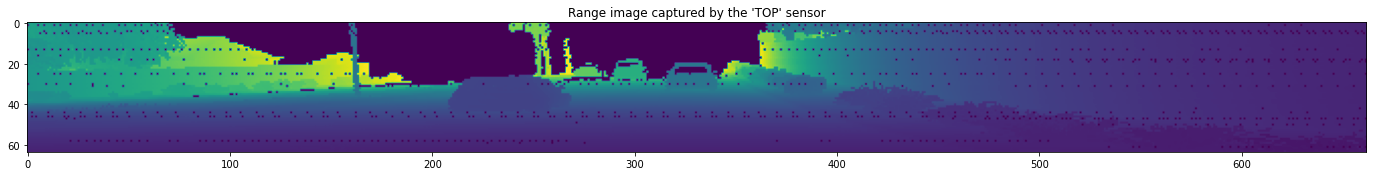

In [20]:
# Example C1-5-4 : Visualize range channel
l1_examples.vis_range_channel(frame, lidar_name, inline=True)

#### 2.1.3: Visualising the Intensity Channel

Exercise C1-5-5
Max. intensity value captured by 'TOP' sensor: 255
Min. intensity value captured by 'TOP' sensor: 0


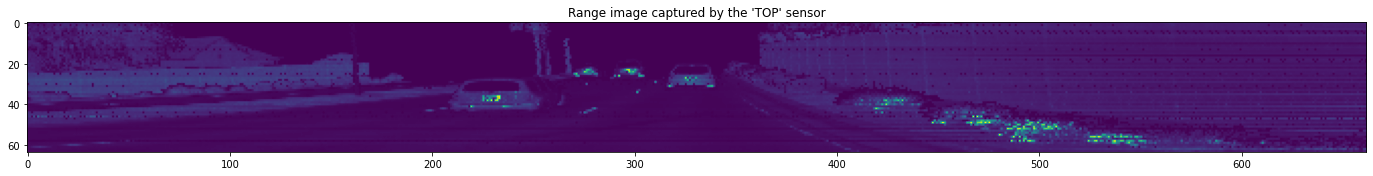

In [21]:
# Exercise C1-5-5 : Visualize intensity channel
l1_exercises.vis_intensity_channel(frame, lidar_name, inline=True)

In the above intensity image we have performed a _contrast adjustment_ scaling method. This heuristic-based approach scales the intensity values to an 8-bit range while handling extreme outliers appropriately. We specifically choose a contrast adjustment approach to mitigate the effect of outliers without increasing noise levels significantly. To do so, we multiply all intensity values by one-half the value of the maximum intensity in the image, then perform a _min-max_ normalisation, i.e., divide all values by `max(intensity) - min(intensity)`.

In the above we see that not only the license plates of the vehicles are visible, but also the bushes to the left, the walls to either side of the vehicle, other foliage e.g., trees, and even several road markings. This is a substantial improvement over the intensity image _without_ scaling and normalisation, of which contains only a very small number of visible features. This is because, in the unmodified intensity image, the brightest points e.g., the license plate, reflect a significantly greater amount of laser light back to the receiver than, say, the road surface. And, as we will see in section "Converting PCL to BEV" below, the LiDAR sensors used in the Waymo Open Dataset (the [Laser Bear Honeycomb](https://blog.waymo.com/2019/08/bringing-3d-perimeter-lidar-to-partners.html)) are much more sensitive to these outlier values than with other devices in other datasets (e.g., the Velodyne HDL-64E from the KITTI dataset).

##### Convert range image to 3D point cloud

In [22]:
# Example C1-5-6 : Convert range image to 3D point-cloud
l1_examples.range_image_to_point_cloud(frame, lidar_name, inline=True)

geometry::PointCloud with 148457 points.

In [23]:
# Example C1-5-6 : Convert range image to 3D point-cloud
visualiser = JVisualizer()
pcd = l1_examples.range_image_to_point_cloud(frame, lidar_name, vis=True, inline=True)
visualiser.add_geometry(pcd)
visualiser.show()

JVisualizer with 1 geometries

### 2.2. Object Detection

In [24]:
import l2_examples
import l2_exercises

In [25]:
####### LESSON 2 EXERCISES & EXAMPLES  START #######

In [26]:
# Define parameters used in subsequent steps
configs = edict()
configs.lim_x = [0, 50]
configs.lim_y = [-25, 25]
configs.lim_z = [-0.3, 3]
configs.bev_width = 608
configs.bev_height = 608
configs.conf_thresh = 0.5

#### 2.2.1: Transform a Point Cloud into a Bird's-Eye View

##### Cropping point clouds

In the code below, we will be cropping the resulting `lidar_pcl` point cloud object to a region of interest (ROI) more desirable for our use case. By selecting a maximum and minimum effective range for our BEV map, we can better ensure higher signal returns and avoid training our detector on LiDAR returns that are decayed beyond a safe limit.

For this exercise, we have chosen to limit the LiDAR point cloud data to the following region:

$$
\begin{align}
    0m \leq p_{x} \geq +50m, \\
    -25m \leq p_{y} \geq + 25m, \\
    -1m \leq p_{z} \geq + 3m. \\
\end{align}
$$

Note that this region of interest discards all LiDAR data outside a $+50m$ window in the lateral direction of motion of the vehicle (i.e., directly _outward_ from the vehicle FOV). Recall above the maximum range of the LiDAR sensors provided in the Waymo Open Dataset of $75m$; by limiting our range to only $50m$ we can ensure higher signal strength for our returns.

In [27]:
# Example C2-3-1 : Crop point cloud
lidar_pcl = l1_examples.range_image_to_point_cloud(frame, lidar_name, vis=False, inline=False)
cropped_pcl = l2_examples.crop_pcl(lidar_pcl, configs, vis=True, inline=True)

JVisualizer with 1 geometries

##### Converting PCL to BEV

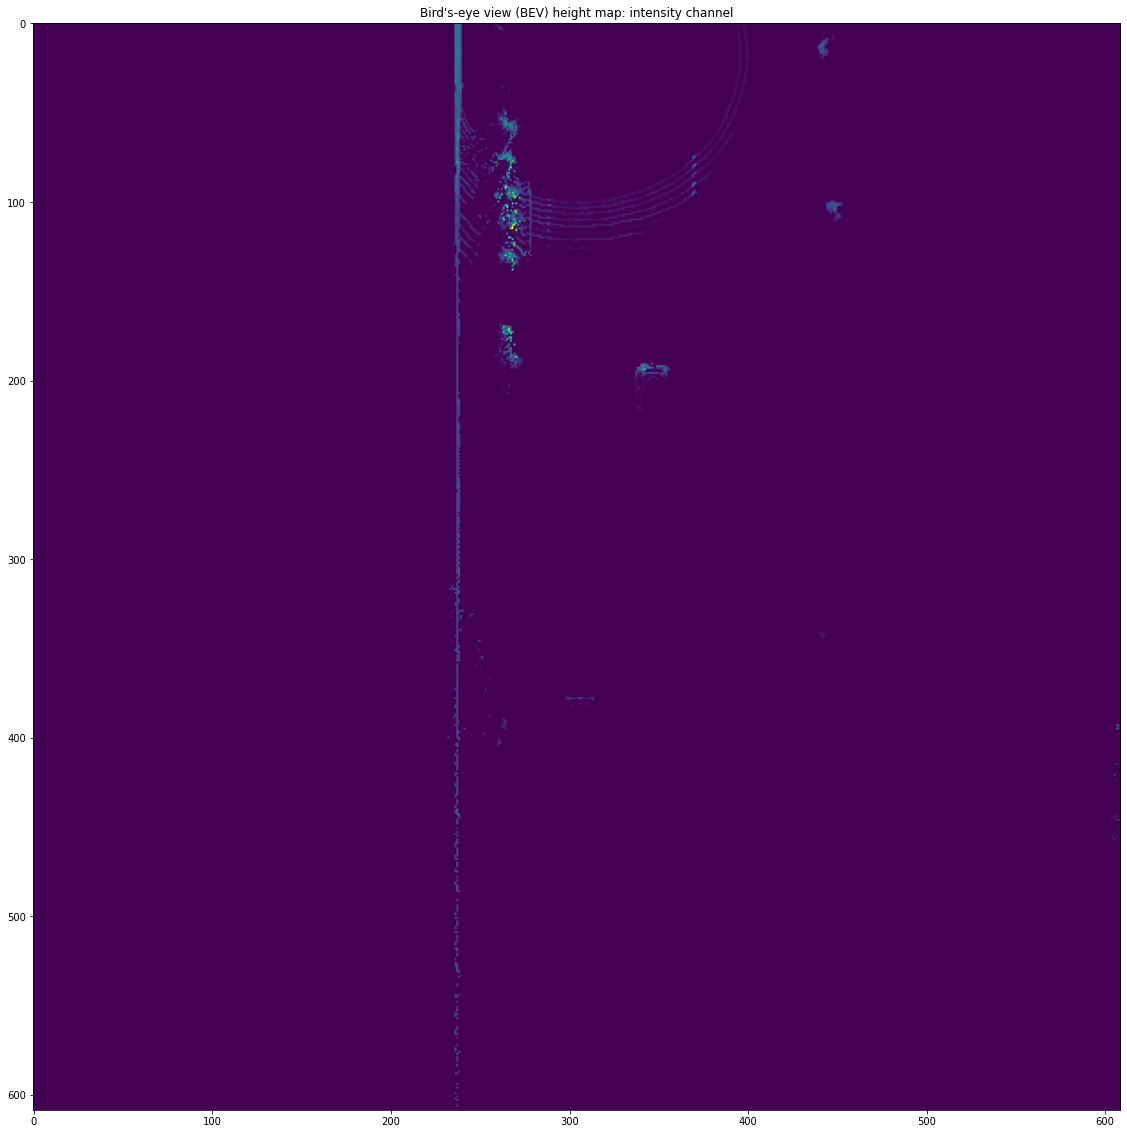

In [28]:
# Exercise C2-3-2 : Transform metric point coordinates to BEV space
l2_exercises.pcl_to_bev(cropped_pcl, configs, vis=True, inline=True)

From the above we see that we have successfully converted the 3D point cloud data into a Bird's-eye view (BEV) image. We visualise the intensity channel and notice something a bit strange: much of the detail in the scene is missing from the visualisation. By choosing to display the intensity channel, we will not get in return a concise representation of the scene from the human-interpretable perspective. Instead, we use the result of the intensity channel to determine the presence of intensity value _outliers_ in the scene that we need to account for. In practise, it is often the case that reflectance, i.e., intensity, varies significantly between LiDAR sensor models. For example, in the Waymo Open Dataset we are using for this exercise, the maximum intensity values are significantly greater here than with another popular LiDAR public dataset, the [KITTI](https://www.cvlibs.net/datasets/kitti/) dataset which uses the Velodyne HDL-64E LiDAR module to capture intensity values.

Let's briefly get a sense of the overall distribution of LiDAR intensity values with the following:

In [29]:
### Binning the intensity values
b = np.array([0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+3, 1e+3, 1e+4, 1e+5, 1e+6, 1e+7])
hist,bins = np.histogram(lidar_pcl[:, 3], bins=b)
print(hist)

[     0      0     24   1379  41109 105499    316     92      0     37
      1      0      0]


We chose to bin the intensity values into 14 bins, each a power of 10, We started with a bin value of $0.0$ and went up 7 orders of magnitude to $10^7$. While these bins are not equally spaced, the logarithmic scale formed above allows us to see that a majority of our LiDAR sensor data for the intensity channel actually lies in just three bins: $10^{-3}, 10^{-2}, 10^{-1}$. We also note that points with intensity values above $1.0$ amounts to just $1%$ of the points in this frame.

Now let's take a look at the maximum intensity value:

In [30]:
# Example C2-3-3 : Minimum and maximum intensity
l2_examples.min_max_intensity(lidar_pcl)

Min. intensity value: 0.000362396240234375, Max. intensity value: 22016.0


We see that the maximum intensity value in this frame is approximately $22016$. From our previous findings, we can safely clip all intensity values above a respectable threshold (e.g., $1.0$) to a max value of $1.0$. This will appropriately handle outliers through a _contrast adjustment_ that will result in a BEV intensity map with more prominent features.

Lastly, we want to point out that while we chose to visualise the BEV map of the _intensity_ channel, we can choose to repeat the task for the other channel data. Namely, _point density_ and _height_. These other two channels will likely produce BEV maps with features that are more easily detectable to the human eye.

#### 2.2.2. Computing Precision & Recall

In this exercise we will look at the performance of two pre-trained models on the 3D BEV map images we have generated. Those two models are the FPN ResNet and the DarkNet (e.g., Complex YOLO). We will visualise the ground-truth bounding boxes along with the model predictions in BEV map-space. Then, we will compute several classification metrics to determine the accuracy of the models.

The [first model](https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1) we look at is the RetinaNet SSD using the ResNet-50 backbone [5]. We have evaluated this model on the Waymo Open Dataset in [Project 1.1](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/tree/main/1-Computer-Vision/1-1-Object-Detection-in-Urban-Environments) and achieved mixed results; for the `TYPE_VEHICLE` class (i.e., vehicles) we achieved decent performance with the detector in most driving scenes. However, the ResNet-50 FPN failed to appropriately detect and localise the `TYPE_PEDESTRIAN` class (i.e., pedestrians). This was especially problematic in our use case, which was specific to urban environments. The only change to this model is the input images themselves — in this exercise we will be fine-tuning the pre-trained model on our BEV map images rather than the 2D RGB images used previously.

The [second model](https://github.com/pjreddie/darknet) is the infamous YOLO real-time object detection model. We use the [DarkNet](https://pjreddie.com/darknet/yolo/) YOLOv4 [6] garden variety architecture pre-trained and adapted to the Waymo Open Dataset. For more information on the individual model architectures, please review their cited papers below.

Note that in this exercise we will only be considering range images as input to our models, and not the 3D point clouds and/or 2D RGB images coupled with the sensor data (i.e., a 'sensor fusion' approach). While many models exist that accomplish this task [7][8][9][10], the scope of this exercise is limited to 3D object detection with range images.

In [31]:
### Current frame number we are looking at
frame_id = 0

In [32]:
### Path to the sequence file we want to analyse
data_fullpath = os.path.join(os.path.join(DIR_BASE, 'dataset'), data_filename) 

##### Counting type and difficulty level

In [33]:
# Example C2-4-2 : count total no. of vehicles and vehicles that are difficult to track
# Recall the number of 'vehicle' objects in the frame we are analysing
l2_examples.count_vehicles(frame)

No. of labelled vehicles: 6, No. of vehicles 'difficult' to detect 0


In [21]:
#### TODO: Describe type and difficulty levels present in dataset

##### Display label bounding boxes on top of BEV map

In [34]:
from misc.helpers import load_object_from_file
import misc.objdet_tools as tools

In [35]:
### Paths to the subdirectories containing the model outputs

In [36]:
results_fullpath_resnet = '/home/workspace/results/fpn-resnet/results_sequence_1_resnet/'
results_fullpath_darknet = '/home/workspace/results/darknet/results_sequence_1_darknet/'

###### Ground-truth bounding boxes

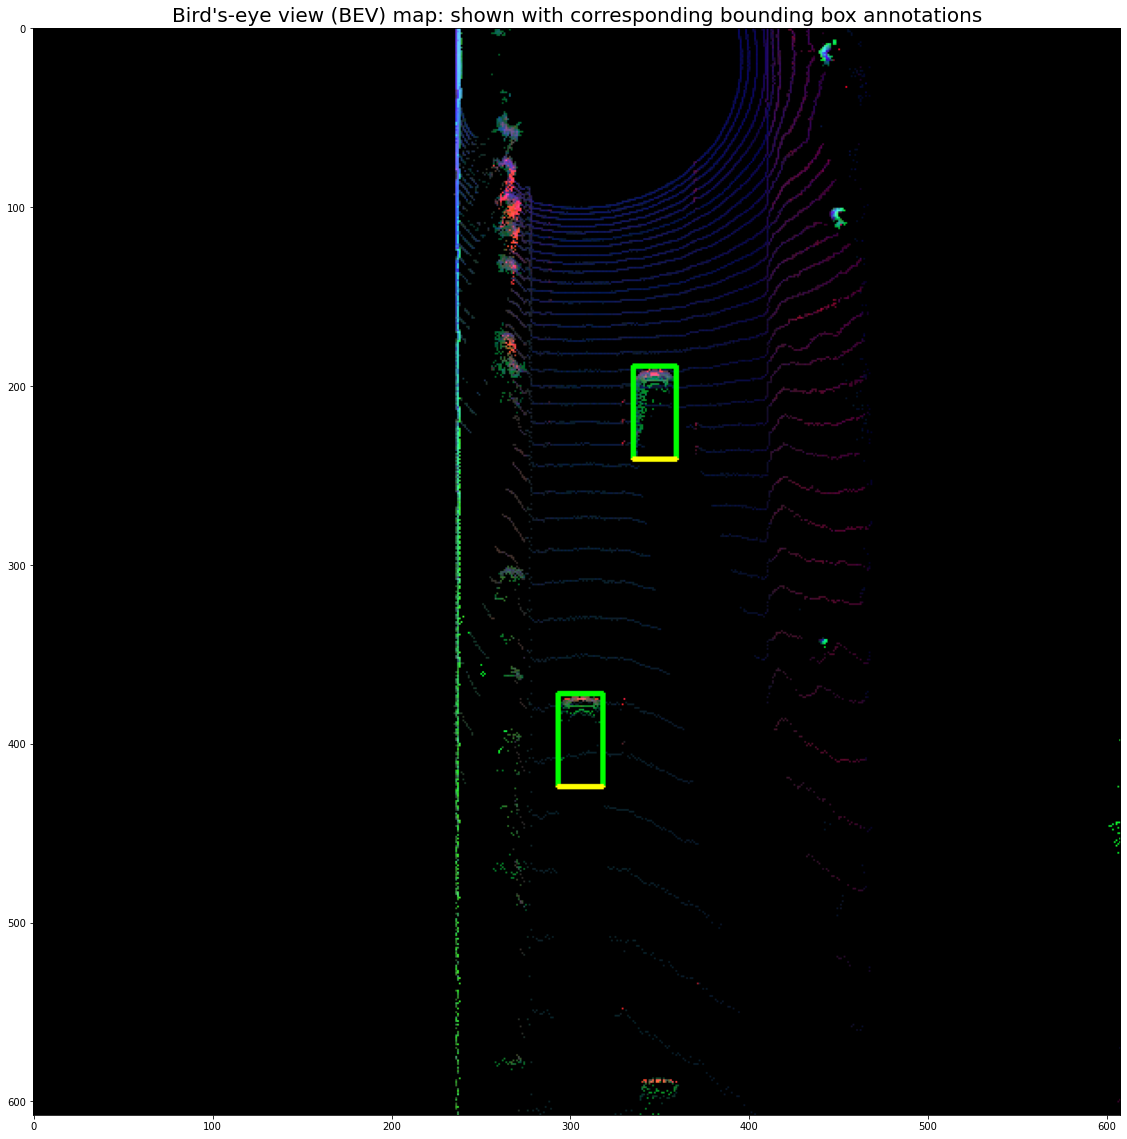

In [37]:
# Example C2-4-3 : Display label bounding boxes on top of BEV map
# Here we look at ground-truth bounding box annotations as fed into the FPN ResNet model
lidar_bev = load_object_from_file(results_fullpath_resnet, data_filename, 'lidar_bev', frame_id)
lidar_bev_labels = l2_examples.render_bb_over_bev(lidar_bev, frame.laser_labels, configs, vis=True, inline=True)

###### Predicted bounding boxes

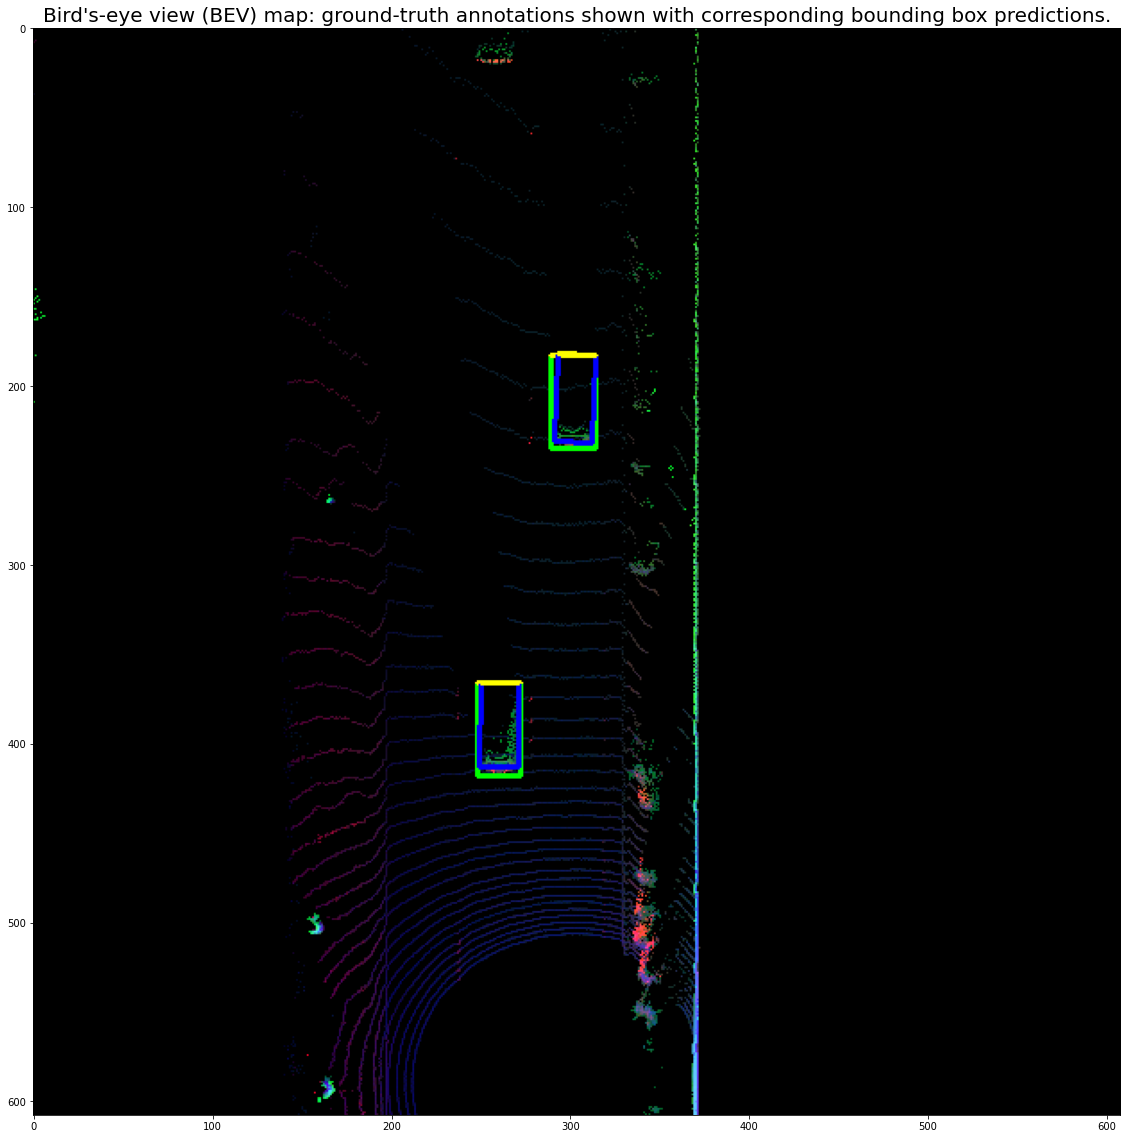

In [39]:
# Example C2-4-4 : Display detected objects on top of BEV map
# Here we render the predictions from the FPN ResNet model
detections = load_object_from_file(results_fullpath_resnet, data_filename, 'detections_fpn_resnet_' + str(configs.conf_thresh), frame_id)
l2_examples.render_obj_over_bev(detections, lidar_bev_labels, configs, vis=True, inline=True)

For this specific frame (`frame_id = 0`), we see that the FPN ResNet model did a fairly good job at predicting the location of the vehicles and appropriately regressing bounding box values that overlap nicely with the ground-truth values.

##### Computing precision and recall

In [ ]:
### TODO: Explain the COCO2017 metrics and other popular benchmarks

In [40]:
# Exercise C2-4-5 : Compute precision and recall (part 1/2 - remove comments only, no action inside functions required)
# Here we store all evaluation results in a list for performance assessment
det_performance_all = []
# For now, we are only fetching the results for a single frame (the current `frame_id`)
det_performance = load_object_from_file(results_fullpath_resnet, data_filename, 'det_performance_fpn_resnet_' + str(configs.conf_thresh), frame_id)
det_performance_all.append(det_performance)  # store all evaluation results in a list for performance assessme

In [41]:
# Exercise C2-4-5 : Compute precision and recall (part 2/2)
l2_exercises.compute_precision_recall(det_performance_all, configs.conf_thresh)

TP = 2, FP = 0, FN = 0
precision = 1.0, recall = 1.0, conf_thres = 0.5



In [63]:
### TODO: Preview detection results for different `frame_id` (e.g., one with more vehicle objects)

## 3. Closing Remarks

##### Alternatives
* Look at other `segment` files from the Waymo Open Dataset.

##### Extensions of task
* Note the LiDAR working principle and equation;
* Compare results to known ground-truth values;
* Explain range image to 3D point cloud conversion.

## 4. Future Work

- ✅ Note the LiDAR working principle and equation;
- ✅ Compare results to known ground-truth values;
- ✅ Provide explanations for range image to 3D point cloud conversion;
- ✅ Add results from Lesson 2: Object Detection with LiDAR Data;
- ⬜️ Add explanation for some of the results in Lesson 2.

## Credits

This assignment was prepared by Dr. Andreas Haja and Dr. Antje Muntzinger et al., 2021 (link [here](https://github.com/udacity/nd013-c2-fusion-starter)).


References
* [1] Sun, Pei, et al. Scalability in Perception for Autonomous Driving: Waymo Open Dataset. arXiv. 2019. [doi:10.48550/ARXIV.1912.04838](https://arxiv.org/abs/1912.04838).
* [2] Zhou, Q-Y, et al. Open3D: A Modern Library for 3D Data Processing. arXiv. 2018. [doi:10.48550/ARXIV.1801.09847](https://arxiv.org/abs/1801.09847).
* [3] Wojtanowski, J., et al. Comparison of 905 nm and 1550 nm semiconductor laser rangefinders’ performance deterioration due to adverse environmental conditions. Opto-Electronics Review, 22(3):183-190. 2014. [doi: 10.2478/s11772-014-0190-2](https://doi.org/10.2478/s11772-014-0190-2).
* [4] Burns, H. et al. System design of a pulsed laser rangefinder, Optical Engineering. 30(3):323-329. 1991. [doi:10.1117/12.55801](https://doi.org/10.1117/12.55801).
* [5] Lin, Tsung-Yi, et al. Focal Loss for Dense Object Detection, arXiv. 2017. [doi:10.48550/ARXIV.1708.02002](https://arxiv.org/abs/1708.02002).
* [6] Wang, C. et al. YOLOv7: Trainable bag-of-freebies sets new state-of-the-art for real-time object detectors. ArXiv. [doi:10.48550/ARXIV.2207.02696](https://arxiv.org/abs/2207.02696).
* [7] Simon, M. et al. Complex-YOLO: Real-time 3D Object Detection on Point Clouds. arXiv. 2018. [doi:10.48550/ARXIV.1803.06199](https://arxiv.org/abs/1803.06199).
* [8] Ali, W. et al. YOLO3D: End-to-end real-time 3D Oriented Object Bounding Box Detection from LiDAR Point Cloud. ArXiv. 2018. [doi:10.48550/ARXIV.1808.02350](https://arxiv.org/abs/1808.02350).
* [9] Chen, X. et al. Multi-View 3D Object Detection Network for Autonomous Driving. arXiv. 2016. [doi:10.48550/ARXIV.1611.07759](https://arxiv.org/abs/1611.07759).
* [10] Charles, R. Q. et al. Frustum PointNets for 3D Object Detection from RGB-D Data. arXiv. 2018. [doi:10.48550/ARXIV.1711.08488](http://arxiv.org/abs/1711.08488).

Helpful resources:
* [Marshall, W. K., et al. Received Optical Power Calculations for Optical Communications Link Performance Analysis. The Telecommunications and Data Acquisition Report. 42(87):32-40. 1986.](hhttps://ntrs.nasa.gov/citations/19870005900);
* [Photodetectors for LiDAR | Hamamatsu Photonics](https://www.hamamatsu.com/content/dam/hamamatsu-photonics/sites/documents/99_SALES_LIBRARY/ssd/Photodetector_lidar_kapd0005e.pdf)
* [LiDAR, Radar, and Cameras: Measuring distance with light in the automotive industry by Hamamatsu Photonics | YouTube](https://youtu.be/D5Hh8EuOD2Q)
* [Photomultiplier Tubes: Basics and Applications (3rd Ed.) | Hamamatsu Photonics](https://www.hamamatsu.com/content/dam/hamamatsu-photonics/sites/documents/99_SALES_LIBRARY/etd/PMT_handbook_v3aE.pdf)
* And a special thanks to H. Kodersdotter for helping me work out the units of LiDAR equations! 😊